In [36]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt

In [74]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    # Compute dynamics
    dsdt = [x[1], -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3]
    return dsdt

gamma=0.1
kappa=1
epsilon=5

def finite_differences(t,x):
    
    #First order finite differences scheme
    
    x2 = x[1:]
    t2 = t[1:]
    
    x1 = x[0:-1]
    t1 = t[0:-1]
    
    dxdt = (x2 - x1)/(t2 - t1)
    t = t1
    
    return (t,dxdt)
    
    

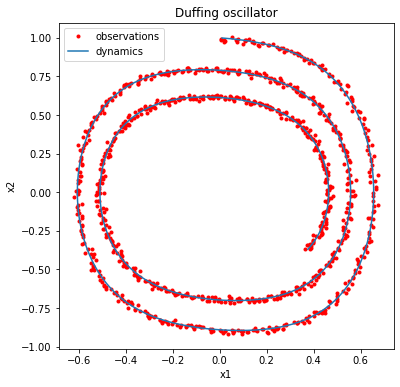

In [75]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
Nt = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n = 2 #Number of state variables
t_span = np.linspace(t0, tf, Nt)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n))
dX[:,0] = x2
dX[:,1] =  -gamma * x2 - kappa * x1 - epsilon * x1 ** 3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.01
E = sigma * np.random.randn(Nt,2)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

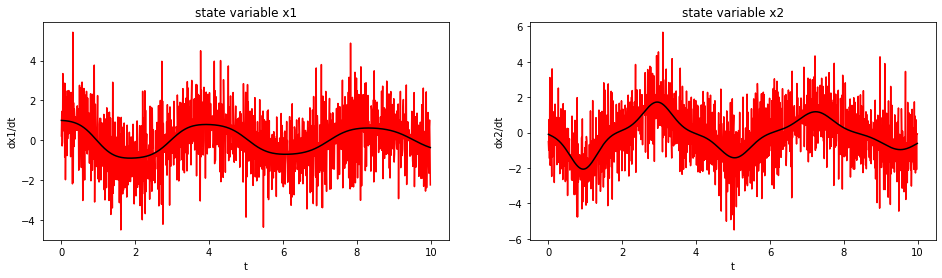

In [80]:
# Compute derivatives from observations

td1,dy1 = finite_differences(t,y1)
td2,dy2 = finite_differences(t,y2)

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
ax1.plot(td1,dy1,'r')
ax1.plot(t[0:-1],dX[0:-1,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')

ax2.plot(td2,dy2,'r')
ax2.plot(t[0:-1],dX[0:-1,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
plt.show()

In [77]:
#Model to approximate functions f1 = dx1 and f2 = dx2
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi_true = poly.fit_transform(X[0:-1,:])#last measurement removed to match derivative dimension
Phi = poly.fit_transform(Y[0:-1,:])
basis_names = poly.get_feature_names()
p = Phi.shape[1]#Number of basis functions

#Function we want to recover using the assumed model
f1_true = dx1
f2_true = dx2

#Approximate function we want to recover
f1 = dy1
f2 = dy2

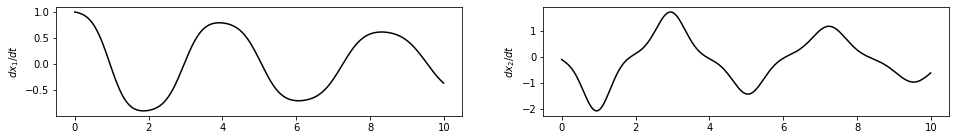

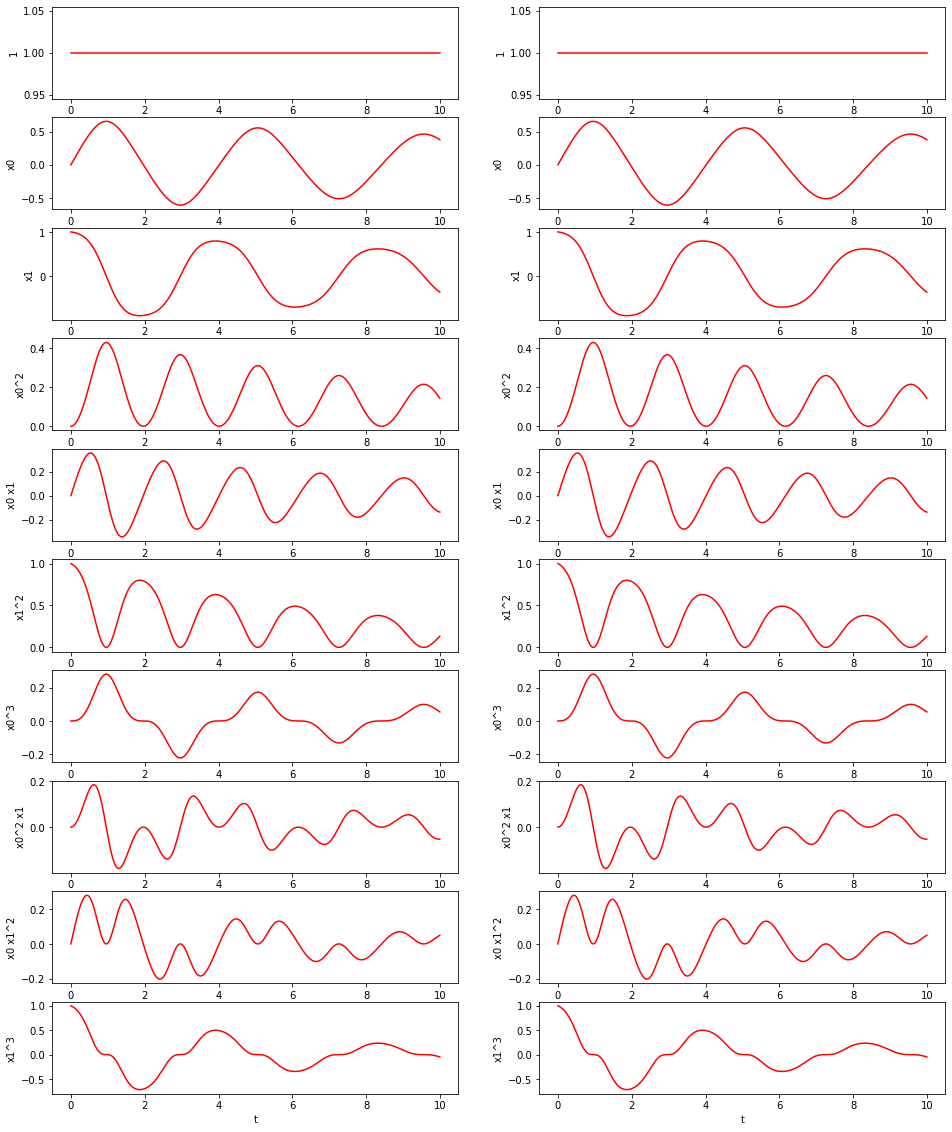

In [84]:
# NOISELESS CASE

#Plot function we want to approximate
fig1,axs1 = plt.subplots(1, n,figsize=(16,2))
axs1[0].plot(t[0:-1],dX[0:-1,0],'k')
axs1[0].set_ylabel(r'$dx_1 / dt$')
axs1[1].plot(t[0:-1],dX[0:-1,1],'k')
axs1[1].set_ylabel(r'$dx_2 / dt$')
#Plot basis functions to approximate 

fig2,axs2 = plt.subplots(p, n,figsize=(16,20))
for i in range(p):
    for j in range(n):
        axs2[i,j].plot(t[0:-1],Phi_true[:,i],'r')
        axs2[i,j].set_xlabel('t')
        axs2[i,j].set_ylabel(basis_names[i])
        


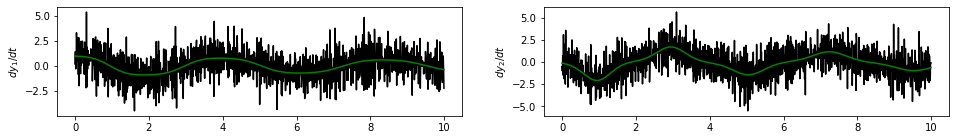

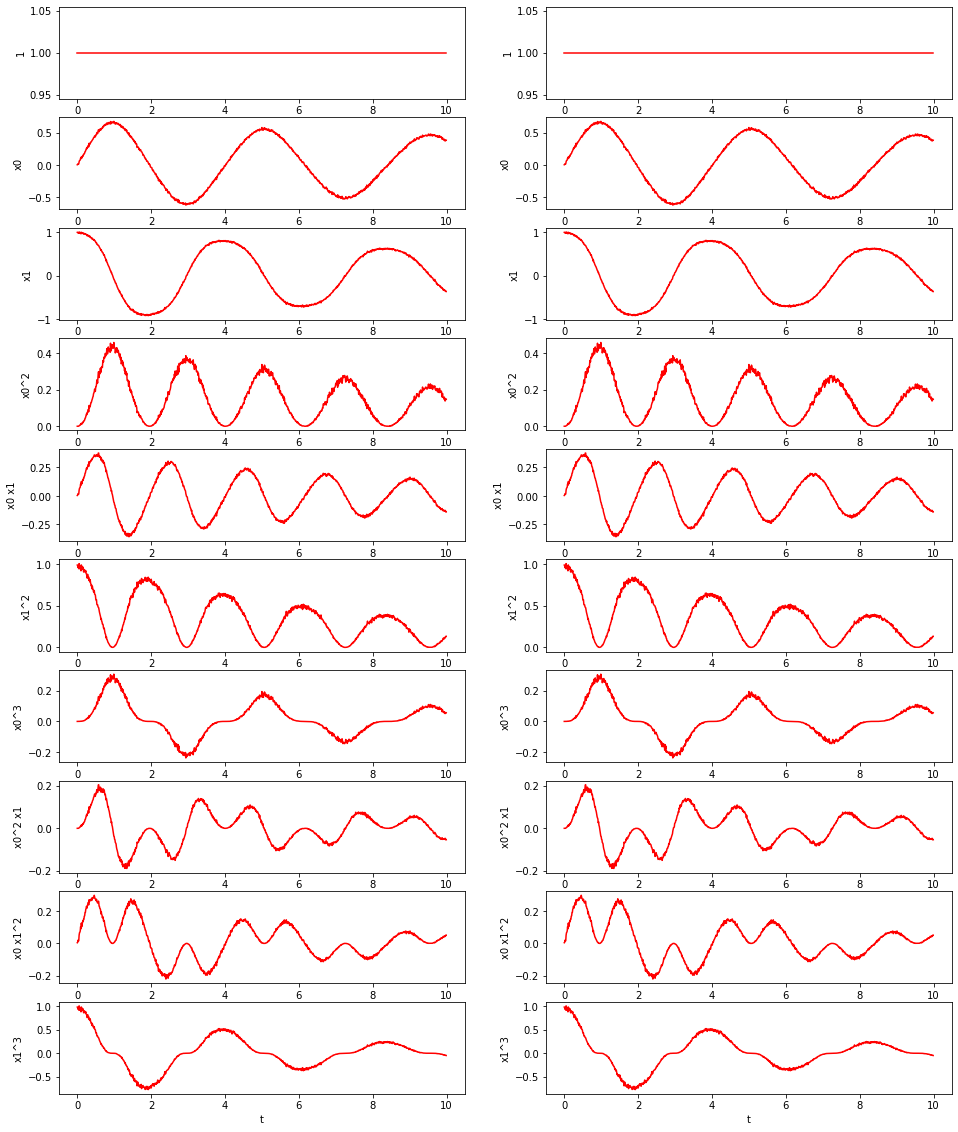

In [87]:
# NOISY CASE
#Plot function we want to approximate
fig1,axs1 = plt.subplots(1, n,figsize=(16,2))
axs1[0].plot(td1,dy1,'k')
axs1[0].plot(t[0:-1],dX[0:-1,0],'g')
axs1[0].set_ylabel(r'$dy_1 / dt$')
axs1[1].plot(td2,dy2,'k')
axs1[1].plot(t[0:-1],dX[0:-1,1],'g')
axs1[1].set_ylabel(r'$dy_2 / dt$')
#Plot basis functions to approximate 

fig2,axs2 = plt.subplots(p, n,figsize=(16,20))
for i in range(p):
    for j in range(n):
        axs2[i,j].plot(t[0:-1],Phi[:,i],'r')
        axs2[i,j].set_xlabel('t')
        axs2[i,j].set_ylabel(basis_names[i])

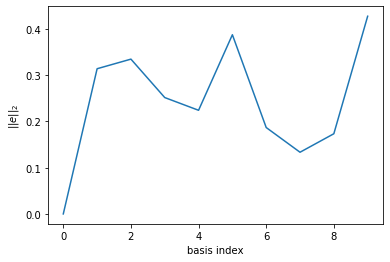

In [94]:
#l_2 norm of the basis functions residual
error = np.linalg.norm(Phi - Phi_true, ord=2, axis=0)
plt.plot(range(p),error)
plt.xlabel('basis index')
plt.ylabel(r'$||e||_2$')
plt.show()